In [1]:
# 准备工作

In [2]:
# 基础运算库
import numpy as np
# 深度学习库
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

# 辅助绘图库
import matplotlib.pyplot as plt

# 时间操作库
import time

# 进度条控制库
from tqdm import tqdm

# 项目1：简单神经网络的前向传播

## 问题1：定义初始参数及激活函数

你需要使用numpy实现神经网络的前向传播过程，并算出输出层的最终输出结果。
**为了完成上述任务我们需要进行如下假设：**

1. 输入的值为\[3,5\]
1. 隐藏层h1的两个权重为\[2,4\]、\[4,-5\]
1. 隐藏层h2的两个权重为\[-1,1\]、\[2,2\]
1. 输出层的权重为\[-3,7\]
1. 所有层不使用偏置
1. 所有隐藏层需添加tanh激活函数

In [3]:
## TODO: 定义一个numpy数组，内容为神经网络的输入数据:
input_data = np.array([3, 5])

In [4]:
# TODO： 定义一个numpy数组，内容为神经网络的隐藏层及输出层权重：

weights = {
    'h11': np.array([2,4]),
    'h12': np.array([4,-5]),
    'h21': np.array([-1,1]),
    'h22': np.array([2,2]),
    'out': np.array([-3,7]),
}

In [5]:
# TODO： 完善下列tanh激活函数：
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

## 问题2：逐层计算神经网络输出

在神经网络的计算中，需要先将需计算层的权重与其输入数据相乘，而后求和，继而通过激活函数的运算，就可以输出到下一层了。

**下面我们将以层为单位，进行运算：**

1. 首先是第一个隐藏层，你需要将输入层的数据与隐藏层的权重相乘、求和、并输入到激活函数中。

In [6]:
print(input_data * weights['h11'])
a = tanh(input_data * weights['h11']).sum()
b = tanh((input_data * weights['h11']).sum())

print(a, b)

[ 6 20]
1.9999877116507956 1.0


In [7]:
# TODO： 将输入层的数据与第一隐藏层的权重相乘、求和、并输入到激活函数中。
hidden_11_value = tanh(input_data * weights['h11']).sum()
hidden_12_value = tanh(input_data * weights['h12']).sum()
hidden_1_output = np.array([hidden_11_value, hidden_12_value])

2. 接下来是第二个隐藏层，这一层的操作与上一层完全相同。<br>

In [8]:
# TODO： 将上层输出的数据与第二隐藏层的权重相乘、求和、并输入到激活函数中。
hidden_21_value = tanh(hidden_1_output * weights['h21']).sum()
hidden_22_value = tanh(hidden_1_output * weights['h22']).sum()
hidden_2_output = np.array([hidden_21_value, hidden_22_value])

3. 最后是输出层，此时只有一个节点需要运算，且无需添加激活函数。<br>

In [9]:
# TODO： 将上层输出的数据与输出层的权重相乘、求和
output = (hidden_2_output * weights['out']).sum()

4. 至此，已经完成了全部运算，下面将这几层的输出打印出来看看吧。
*注：output应为9.887385002294863*

In [10]:
print(output)

9.887385002294863


# 项目2：CIFAR-10图像分类

## 前置准备

本项目使用的数据集可以从torchvision库中直接导出，下面是一些基础数据操作（数据下载可能需要几分钟，请耐心等待）。<br>

In [11]:
##定义对图像的各种变换操作，包括把array转换为tensor，对图像做正则化
#transforms.Compose主要是用于常见的一些图形变换，例如裁剪、旋转
#遍历list数组，对img依次执行每个transforms操作
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.48216, 0.44653), 
                                                    (0.24703, 0.24349, 0.26159))])

#导出torchvision里的CIFAR10数据集，root是把数据下载之后存放的目录，train控制是不是在训练阶段，download控制是不是需要下载，transform把一系列的图像变换传入进来。
trainset = torchvision.datasets.CIFAR10(root = '../../resource/course_data/',
                                        train = True,
                                        download = True,
                                        transform = transform)
testset = torchvision.datasets.CIFAR10(root = '../../resource/course_data/',
                                        train = False,
                                        download = True,
                                        transform = transform)

#用来把训练数据分成多个小组，此函数每次抛出一组数据。
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

#用来把测试数据分成多个小组，此函数每次抛出一组数据。
testloader = torch.utils.data.DataLoader(testset, batch_size = 16, shuffle=False)

170499072it [00:49, 3441317.66it/s]                               


Extracting ../../resource/course_data/cifar-10-python.tar.gz to ../../resource/course_data/
Files already downloaded and verified


数据下载完成后，我们就可以简单查看数据label，看看是否和练习说明中的数据集介绍对的上。

In [12]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

下面我们再来检查一下数据图像。

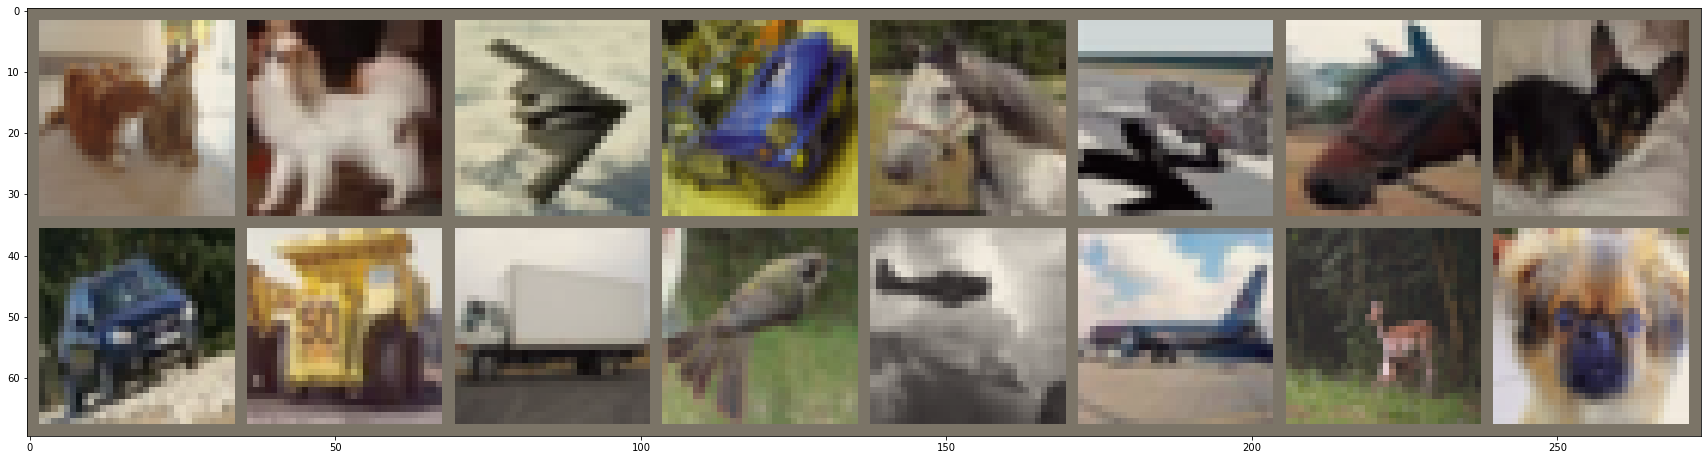

In [13]:
#把图片进行可视化展示
#定义画图的函数
def imshow(inp, title = None):
    """Imshow for Tensor."""

    # 定义画图的画布
    fig = plt.figure(figsize = (30, 30))

    # 转换图片的维度
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # 对图片进行标准化
    inp = std * inp + mean

    # 整个图片数组的值限制在指定值a_min, 与a_max之间
    inp = np.clip(inp, 0, 1)

    # 对图片进行可视化展示
    plt.imshow(inp,)

# 获取一个batch的数据
inputs, classes = next(iter(trainloader))

# 以网格的格式展示，作用是将若干幅图像拼成一副图像
out = torchvision.utils.make_grid(inputs)

# plt.imshow()就可以显示图片同时也显示其格式
imshow(out, title = [trainset.classes[x] for x in classes])

## 问题1：搭建简单神经网络
数据准备就绪后，就需要你来搭建一个简单神经网络。<br>

In [14]:
# TODO： 定义一个层3全连接神经网络，输入维度是32*32*3，第一层输出维度是1000，第二层输出维度是500，第三层输出维度是10
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 1000) # 需补全
        self.fc2 = nn.Linear(1000, 500) # 需补全
        self.fc3 = nn.Linear(500, 10) # 需补全

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.fc3(x)

# 实例化神经网络的类
net = Net()

在定义好模型结构之后，还需确定损失函数及优化器。

In [15]:
# 定义损失函数 - 交叉熵
criterion = nn.CrossEntropyLoss()

# 定义优化器，将神经网络的参数都传入优化器，并定义学习率
optimizer = optim.Adam(net.parameters(), lr = 3e-4)

## 问题2：神经网络的训练

模型主要内容都已完成，下面就可以进行训练了。在模型训练过程中，一般遵循如下步骤：

1. 大for循环-epochs，用于管理一套数据循环训练几遍
1. 小for循环-step，用于以batchsize为单位，从dataloader中调取数据
1. 清空优化器的梯度
1. 读入data和label，并进行形状变换（可做可不做）
1. 运行模型前向传播过程
1. 基于模型输出生成最终结果
1. 计算损失
1. 基于损失计算梯度
1. 基于梯度更新参数

In [16]:
# TODO： 训练模型
num_epochs = 10
since = time.time()
net.train()

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} / {num_epochs}')

    running_loss = 0.0
    running_corrects = 0

    # 从trainloader里循环取出每一批次数据
    for data in tqdm(trainloader):
        # TODO: 补全代码
        inputs, labels = data
        inputs = inputs.view(-1, 32 * 32 * 3)
        optimizer.zero_grad()
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 一个批次数据的损失函数的计算
        running_loss += loss.item() * inputs.size(0)

        # 一个批次数据准确率的计算
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / trainloader.dataset.data.shape[0]
    epoch_acc = running_corrects.double() / trainloader.dataset.data.shape[0]

    print('train loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    print('-' * 20)

time_elapsed = time.time() - since
print('Trainning complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1 / 10


 16%|█▌        | 496/3125 [00:11<00:53, 49.07it/s]

## 问题3：模型测评

完成模型训练后，还需对模型进行测评，验证模型在测试集上的精度。
Tips：在模型训练日志中，也有打印精确度acc，但这是模型在训练集上的精度，而不是测试集上的精度哦。你可以观察观察训练集精度与测试集精度，看看有没有什么差异。

In [ ]:
# TODO: 完成模型测评
correct, total = 0, 0
net.eval()

for data in tqdm(testloader):
    inputs, labels = data
    inputs = inputs.view(-1, 32 * 32 * 3)
    outputs = net(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('The testing set accuracy of the network is: %d %%' % (100 * correct / total))

100%|██████████| 625/625 [00:03<00:00, 157.71it/s]

The testing set accuracy of the network is: 53 %
